## Loading libraries

In [1]:
#  short workbook to convert currency string into float number value
import pandas as pd
import numpy as np

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'
from statsmodels.tsa.seasonal import seasonal_decompose

## Loading dataset

In [2]:
df = pd.read_csv('ma_lga_12345.csv', index_col = 0, parse_dates = True)

## Selecting one type of properties

Houses with 2-bedrooms

In [3]:
df_h2 = df.reset_index()
df_h2 = df_h2[(df_h2.type == 'house') & (df_h2.bedrooms == 2)]

In [4]:
# reseting index to datetime
df_h2 = df_h2.set_index('saledate').drop(['type', 'bedrooms'], axis = 1)

In [5]:
df_h2

,MA
saledate,
2007-09-30,441854
2007-12-31,441854
2008-03-31,441854
2008-06-30,441854
2008-09-30,451583
2008-12-31,440256
2009-03-31,442566
2009-06-30,446113
2009-09-30,440123


## EDA

#### Seasonal decomposition

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
decomposition = seasonal_decompose(df_h2['MA'], model='multiplicative')

Decomposed data show the upward trend over yeear and distinct seasonality during each year

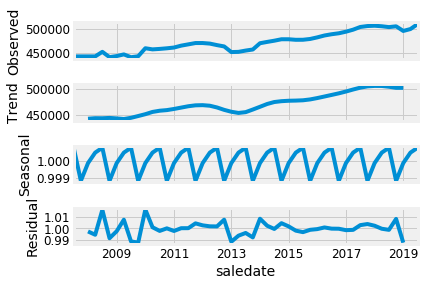

In [8]:
decomposition.plot();

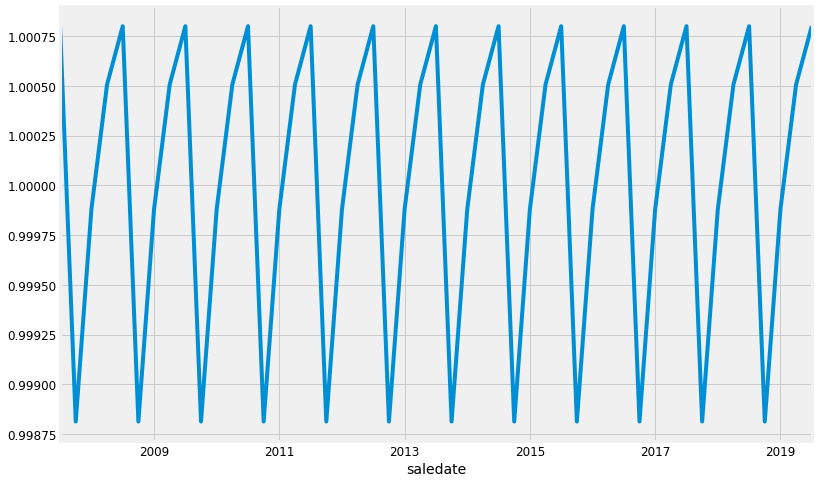

In [9]:
decomposition.seasonal.plot(figsize = (12,8));

#### Data length and data period

In [10]:
# number of data points
len(df_h2['MA'])

49

Data is not completed for the first and the last year. In year 2007 we have only data for two last quarters and in year 2019 we have only data for 3 first quarters. For data completeness I removed data in 2007.
My train data will till end of 2018 and my test data will be year 2019.

In [11]:
df_h2[:8]

,MA
saledate,
2007-09-30,441854
2007-12-31,441854
2008-03-31,441854
2008-06-30,441854
2008-09-30,451583
2008-12-31,440256
2009-03-31,442566
2009-06-30,446113


In [12]:
df_h2.tail()

,MA
saledate,
2018-09-30,504318
2018-12-31,506001
2019-03-31,496133
2019-06-30,500158
2019-09-30,510712


In [13]:
# removing data for 2007
df_h2 = df_h2[2:]

## Creating RNN model

#### Train & Test data

In [14]:
len(df_h2['MA']) - 3

44

In [15]:
train = df_h2.iloc[:44]
test = df_h2.iloc[44:]

#### Scaling data

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

# fit to the training data
scaler.fit(train)

# transform training data
scaled_train = scaler.transform(train)

# transform test data
scaled_test = scaler.transform(test)

The next part will feed in the batches of data into the RNN model so that [t1, t2, t3] ==> t4

Keras have the preprocessing object that puts the data into this format

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
scaled_test
# in scaled test data we may come across the data point that is larger than 1 (because we used the train data for the fit)
# it is not a problem since everything is more or less the same in the scale of 0 to 1

array([[0.83441341],
       [0.89437616],
       [1.05160521]])

In [133]:
# numbr of input is the one full cycle of the seasonality
# for my quarterly data that should be 4 to pick up on the yearly seasonality

# n_features specifies how many columns we have
n_input = 4
n_features = 1

In [134]:
# pass the data to generator
# data = scaled_train and target = scaled_train

# batch size refers to how many consecutive batches the timeseries generator produces at one run
# with batch size 2 we have two batches of data 1-4 and 2-5 and targets 5 and 6
# typically in RNN smaller batches mean better training

generator = TimeseriesGenerator(scaled_train, scaled_train, length= n_input, batch_size= 1)

In [135]:
len(scaled_train)

44

In [136]:
len(generator) # this is the len of the scaled train - the number of features

40

In [137]:
scaled_train[:5]

array([[0.02578771],
       [0.02578771],
       [0.17072626],
       [0.00198138],
       [0.03639479]])

In [138]:
X, y = generator[0]

In [139]:
X

array([[[0.02578771],
        [0.02578771],
        [0.17072626],
        [0.00198138]]])

In [140]:
y

array([[0.03639479]])

#### RNN model

In [141]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [142]:
model = Sequential()

model.add(LSTM(150, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [110]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [143]:
model.fit_generator(generator, epochs = 40)

Epoch 1/40
40/40 [==============================] - 0s 8ms/step - loss: 0.1293
Epoch 2/40
40/40 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 3/40
40/40 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 4/40
40/40 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 5/40
40/40 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 6/40
40/40 [==============================] - 0s 8ms/step - loss: 0.0120
Epoch 7/40
40/40 [==============================] - 0s 11ms/step - loss: 0.0129
Epoch 8/40
40/40 [==============================] - 0s 11ms/step - loss: 0.0125
Epoch 9/40
40/40 [==============================] - 0s 11ms/step - loss: 0.0118
Epoch 10/40
40/40 [==============================] - 0s 7ms/step - loss: 0.0114
Epoch 11/40
40/40 [==============================] - 0s 5ms/step - loss: 0.0115
Epoch 12/40
40/40 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 13/40
40/40 [===========================

In [144]:
model.history.history.keys()

dict_keys(['loss'])

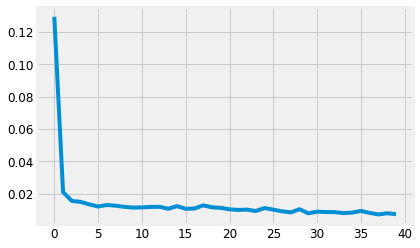

In [145]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

#### Creating validation set

In [114]:
## our model right now sees 4 previous steps and predict step 5

In [147]:
# this are last four points of the training set
first_eval_batch = scaled_train[-4:]

In [148]:
first_eval_batch

array([[1.        ],
       [0.98313594],
       [0.95635009],
       [0.98142272]])

In [150]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [151]:
model.predict(first_eval_batch)

array([[1.0142369]], dtype=float32)

## Forecast with RNN

In [152]:
test_predictions = [] # holding predicitons

# the last n-input points from the training set
first_eval_batch = scaled_train[-n_input:] 

In [153]:
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [154]:
for i in range(len(test)):
    
    # one time step ahead of historical points
    current_pred = model.predict(current_batch)[0] #having the right 1 dim format
    
    # store that prediction
    test_predictions.append(current_pred)
    
    #update batch to include the prediction
    # drop the first value of the current batch and add the prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis = 1)

In [155]:
test_predictions

[array([1.0142369], dtype=float32),
 array([1.0530746], dtype=float32),
 array([1.095572], dtype=float32)]

In [156]:
scaled_test

array([[0.83441341],
       [0.89437616],
       [1.05160521]])

In [157]:
true_predictions = scaler.inverse_transform(test_predictions)

In [158]:
true_predictions

array([[508203.65372705],
       [510810.63241172],
       [513663.27014971]])

In [159]:
test['Predictions'] = true_predictions

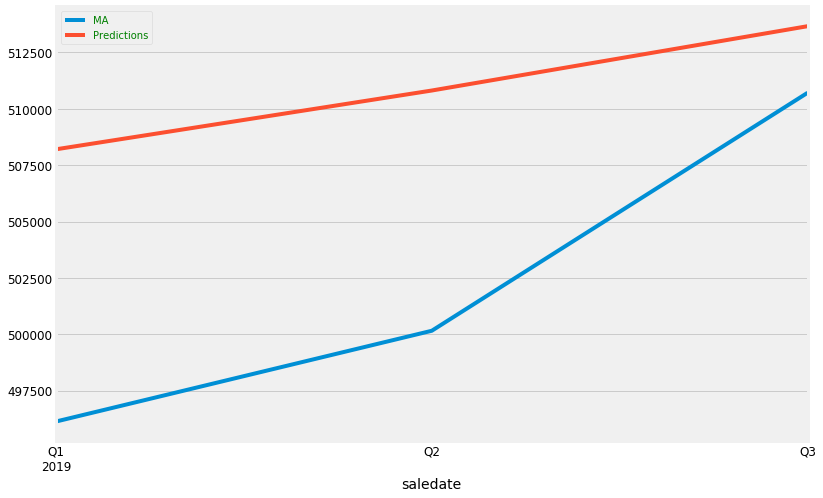

In [160]:
test.plot(figsize = (12,8))

In [ ]:
# model.save('modelRNN1.h5')

In [161]:
# check the error 

from statsmodels.tools.eval_measures import rmse

error = rmse(test['MA'], test['Predictions'])
print(f"Error value: {error}")
print(f"Mean predictions value {test['Predictions'].mean()}")

Error value: 9449.678199004204
Mean predictions value 510892.5187628269


In [163]:
# what is the scale of the error
mean_test = test.MA.mean()

print(f"The avg value of the test set: {mean_test}")

The avg value of the test set: 502334.3333333333


## Retrain on the whole dataset

## Forecast a year into the future